## **Machine Learning - Clasificación**

---
### **Librerías**

In [5]:
import warnings

warnings.filterwarnings("ignore")  # Suprime warnings

import pandas as pd
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


---
### **1. Cargar dataset y definir `X` e `y`**

In [6]:
# Ruta de los outputs
input_folder = "../../data/outputs/3_eda"

# Cargar el DataFrame preprocesado que incluye el texto concatenado y la variable objetivo
texto_medicamentos_df = pd.read_csv(
    os.path.join(input_folder, "texto_concatenado_medicamentos.csv")
)
print("Columnas:", texto_medicamentos_df.columns.tolist())

# Aseguramos que la variable objetivo esté presente (por ejemplo, "descripcion_nivel_anatomico")
assert (
    "descripcion_nivel_anatomico" in texto_medicamentos_df.columns
), "No se encontró la variable objetivo."

output_folder = "../../images/classification/"
os.makedirs(output_folder, exist_ok=True)

Columnas: ['medicamento', 'descripcion_nivel_anatomico', 'descripcion_nivel_2_subgrupo_terapeutico', 'descripcion_nivel_3_subgrupo_terapeutico_farmacologico', 'descripcion_nivel_4_subgrupo_terapeutico_farmacologico_quimico', 'descripcion_nivel_5_principio_activo', 'texto_completo']


In [8]:
# Cargar el vectorizador TF-IDF y la matriz vectorizada
with open(os.path.join(input_folder, "tfidf_vectorizer.pkl"), "rb") as f:
    tfidf_vectorizer = pickle.load(f)

with open(os.path.join(input_folder, "tfidf_matrix.pkl"), "rb") as f:
    tfidf_matrix = pickle.load(f)

# Definir features (X) y variable objetivo (y)
X = tfidf_matrix  # Matriz TF-IDF
# Queremos predecir el nivel anatomico, es decir, sistema nervioso, digestivo, etc.
y = texto_medicamentos_df["descripcion_nivel_anatomico"]
# Rellenar valores nulos
y = y.fillna("Desconocido")

# Convertir categorías a valores numéricos
le = LabelEncoder()
y = le.fit_transform(y) # 1,2,3,4,5, ...
# categorias_originales = le.inverse_transform(y) # si queremos revertir la codificación

# Mostrar las clases y sus valores correspondientes
clases_originales = le.inverse_transform(np.unique(y))
print("Clases originales y sus valores:")
for valor, clase in enumerate(clases_originales):
    print(f"{valor}: {clase}")


Clases originales y sus valores:
0: Desconocido
1: antiinfecciosos para uso sistémico
2: antineoplásicos e inmunomoduladores
3: dermatológicos
4: preparados hormonales sistémicos, excluyendo hormonas sexuales e insulinas
5: productos antiparasitarios, insecticidas y repelentes
6: sangre y órganos hematopoyéticos
7: sistema cardiovascular
8: sistema digestivo y metabolismo
9: sistema genitourinario y hormonas sexuales
10: sistema musculoesquelético
11: sistema nervioso
12: sistema respiratorio
13: varios
14: órganos sensoriales


---
### **2. Devidir en `train` y `test`**

In [9]:
# Dividir en entrenamiento (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

---
### **3. Clasificación del `grupo anatómico` de los medicamentos**

---
### **3.1 Regresión logística (LR)**

---
##### **Entrenamiento**

In [10]:
# --- Regresión Logística ---
print("### Grid Search: Regresión Logística ###")

# Definir el grid de hiperparámetros. Por ejemplo, se puede optimizar el parámetro C
param_grid_lr = {
    "C": [100],
    "penalty": ["l2"],  # Para 'l1' se necesita solver 'liblinear'
    "solver": ["lbfgs"],  # lbfgs soporta multiclass
    "max_iter": [1000],
}

### Grid Search: Regresión Logística ###


In [11]:
lr = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [100], 'max_iter': [1000], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy')

In [12]:
print("Mejores hiperparámetros (LogReg):", grid_lr.best_params_)
print("Mejor CV Accuracy (LogReg): {:.2f}".format(grid_lr.best_score_))

Mejores hiperparámetros (LogReg): {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor CV Accuracy (LogReg): 0.95


---
##### **Test**

In [14]:
# Evaluación en el conjunto de entrenamiento y test
best_lr = grid_lr.best_estimator_
y_train_pred_lr = best_lr.predict(X_train)
y_test_pred_lr = best_lr.predict(X_test)

print(
    "Regresión Logística - Train Accuracy: {:.2f}".format(
        accuracy_score(y_train, y_train_pred_lr)
    )
)
print(
    "Regresión Logística - Test Accuracy: {:.2f}".format(
        accuracy_score(y_test, y_test_pred_lr)
    )
)
print(
    "\nReporte de Clasificación - Regresión Logística (Test):\n",
    classification_report(y_test, y_test_pred_lr, zero_division=0),
)

Regresión Logística - Train Accuracy: 0.99
Regresión Logística - Test Accuracy: 0.95

Reporte de Clasificación - Regresión Logística (Test):
               precision    recall  f1-score   support

           0       0.90      0.78      0.83       562
           1       0.93      1.00      0.96       215
           2       0.93      0.99      0.96       222
           3       0.89      0.96      0.92        89
           4       0.93      0.98      0.96        58
           5       0.83      0.62      0.71         8
           6       0.92      0.97      0.95       170
           7       0.98      0.99      0.98       710
           8       0.98      0.99      0.98       345
           9       0.96      0.97      0.97       170
          10       0.98      0.96      0.97       142
          11       0.95      0.98      0.97       922
          12       0.96      0.96      0.96       221
          13       0.95      0.95      0.95        73
          14       0.99      0.93      0.96    

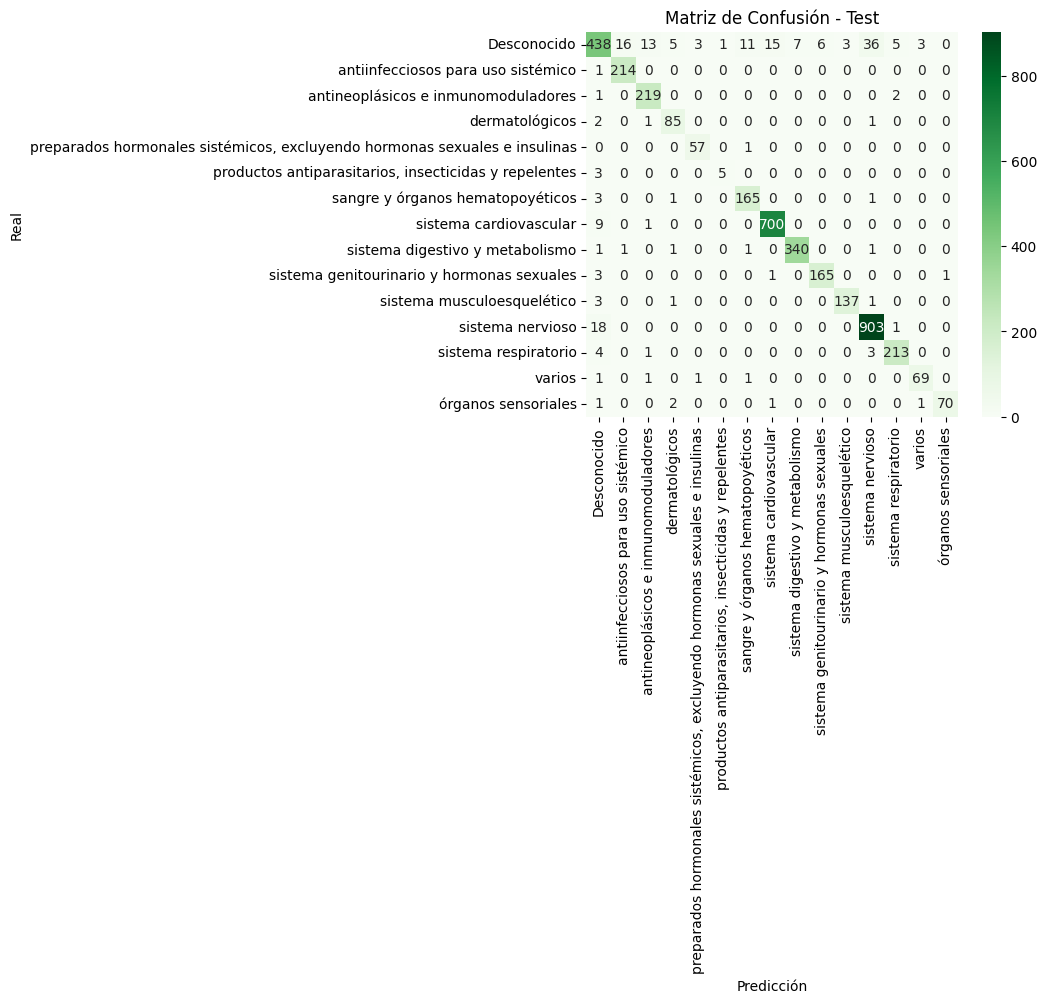

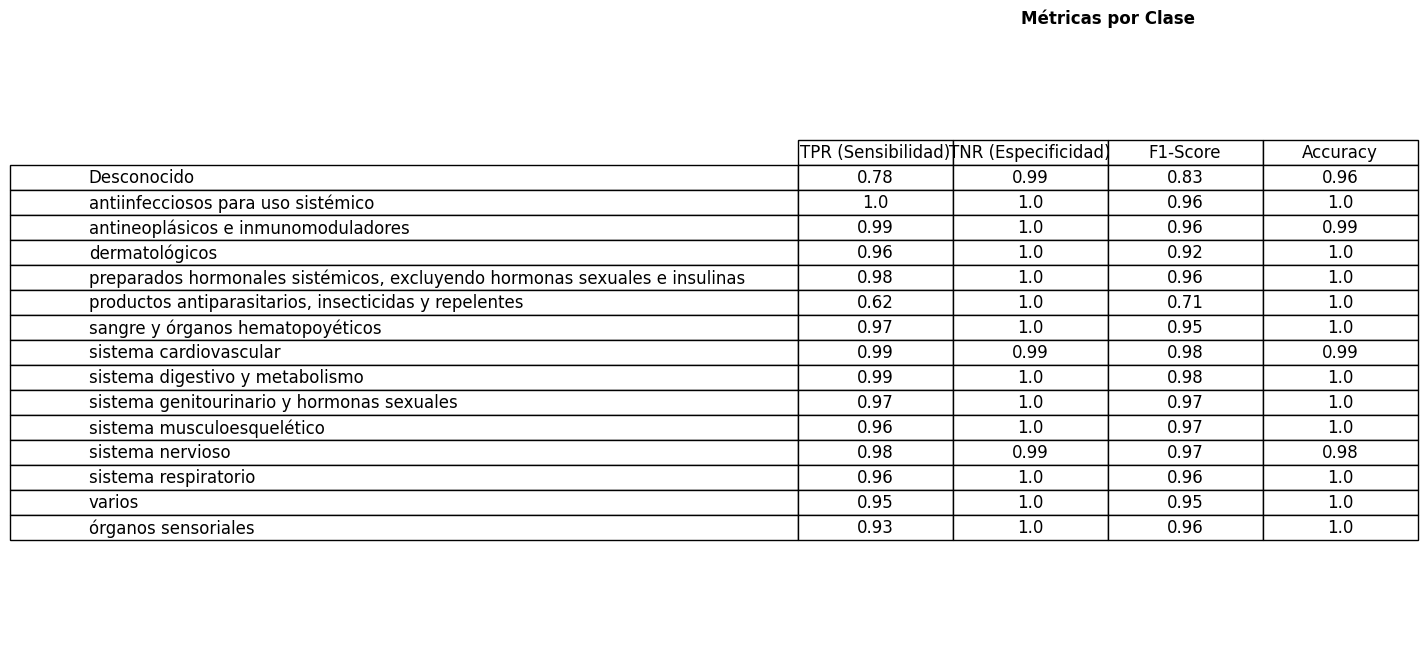

In [35]:
# Función para mostrar la matriz de confusión
def plot_test_confusion_matrix_metrics(y_test, y_pred_test, model):
    """
    Genera y muestra de forma visual la matriz de confusión para el conjunto de test y, en una figura aparte,
    muestra una tabla con los indicadores TPR (Sensibilidad), TNR (Especificidad), F1-Score y Accuracy para cada clase.
    
    Parámetros:
        y_test (array-like): Etiquetas reales del conjunto de test.
        y_pred_test (array-like): Predicciones del modelo sobre el conjunto de test.
        model (str): Nombre del modelo utilizado para la predicción (ej. "RL").
    
    Nota:
        Se asume que la variable global 'le' (LabelEncoder) ha sido definida y entrenada previamente
        para obtener los nombres originales de las clases.
    """

    # Calcular la matriz de confusión para test
    cm = confusion_matrix(y_test, y_pred_test)
    class_names = le.classes_
    n_classes = len(class_names)

    # Mostrar la matriz de confusión con ejes ordenados
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión - Test')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"matriz_confusion_test_{model}.png"), bbox_inches='tight')
    plt.show()

    # Calcular métricas por clase
    metrics = {"Clase": [], "TPR (Sensibilidad)": [], "TNR (Especificidad)": [], "F1-Score": [], "Accuracy": []}
    total = cm.sum()
    for i in range(n_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total - (TP + FN + FP)
        
        tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
        tnr = TN / (TN + FP) if (TN + FP) > 0 else 0
        f1 = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
        acc = (TP + TN) / total if total > 0 else 0
        
        metrics["Clase"].append(class_names[i])
        metrics["TPR (Sensibilidad)"].append(round(tpr, 2))
        metrics["TNR (Especificidad)"].append(round(tnr, 2))
        metrics["F1-Score"].append(round(f1, 2))
        metrics["Accuracy"].append(round(acc, 2))
    
    df_metrics = pd.DataFrame(metrics).set_index("Clase")
    
    # Visualizar la tabla de métricas
    fig, ax = plt.subplots(figsize=(8, 0.5 + 0.5 * n_classes))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df_metrics.values,
                     colLabels=df_metrics.columns,
                     rowLabels=df_metrics.index,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    plt.title("Métricas por Clase", fontweight="bold")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"metrics_test_{model}.png"), bbox_inches='tight')
    plt.show()

# Matriz de confusión de la regresión logística
plot_test_confusion_matrix_metrics(y_test, y_test_pred_lr, 'RL')

---
#### **3.2 Random Forest (RF)**

---
##### **Entrenamiento**

In [19]:
# --- RandomForest ---
print("\n### Grid Search: RandomForestClassifier ###")

param_grid_rf = {
    "n_estimators": [200],
    "max_depth": [30],
    "min_samples_split": [2],
}


### Grid Search: RandomForestClassifier ###


In [20]:
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [30], 'min_samples_split': [2],
                         'n_estimators': [200]},
             scoring='accuracy')

In [21]:
print("Mejores hiperparámetros (RF):", grid_rf.best_params_)
print("Mejor CV Accuracy (RF): {:.2f}".format(grid_rf.best_score_))

Mejores hiperparámetros (RF): {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Mejor CV Accuracy (RF): 0.96


---
##### **Test**

In [22]:
# Evaluación en el conjunto de entrenamiento y test
best_rf = grid_rf.best_estimator_
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

print(
    "RandomForest - Train Accuracy: {:.2f}".format(
        accuracy_score(y_train, y_train_pred_rf)
    )
)
print(
    "RandomForest - Test Accuracy: {:.2f}".format(
        accuracy_score(y_test, y_test_pred_rf)
    )
)
print(
    "\nReporte de Clasificación - RandomForest (Test):\n",
    classification_report(y_test, y_test_pred_rf, zero_division=0),
)

RandomForest - Train Accuracy: 1.00
RandomForest - Test Accuracy: 0.97

Reporte de Clasificación - RandomForest (Test):
               precision    recall  f1-score   support

           0       0.94      0.85      0.90       562
           1       0.93      1.00      0.97       215
           2       0.98      1.00      0.99       222
           3       0.83      0.99      0.90        89
           4       0.95      1.00      0.97        58
           5       1.00      0.50      0.67         8
           6       0.96      0.98      0.97       170
           7       0.99      1.00      0.99       710
           8       0.99      1.00      0.99       345
           9       0.98      0.99      0.99       170
          10       0.99      0.93      0.96       142
          11       0.97      1.00      0.98       922
          12       0.98      0.98      0.98       221
          13       0.95      0.86      0.91        73
          14       1.00      0.95      0.97        75

    accuracy 

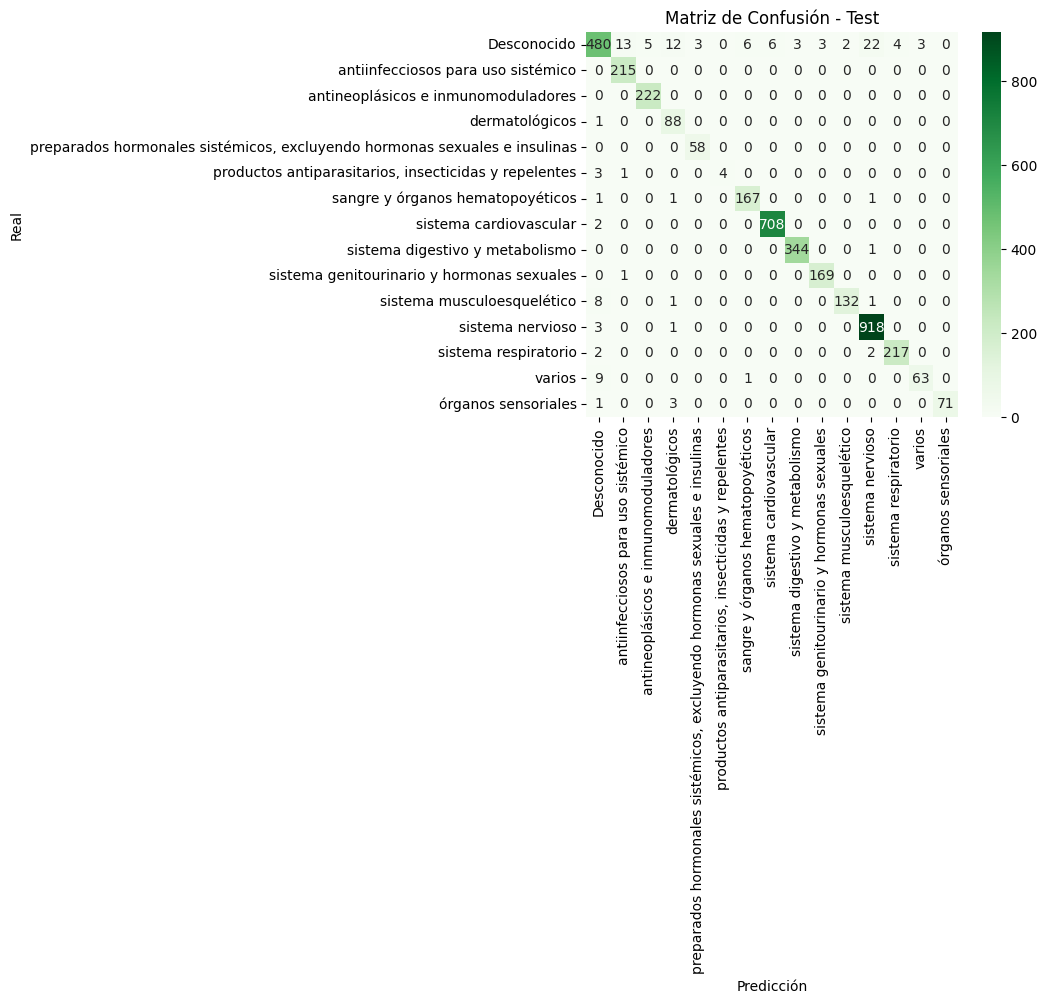

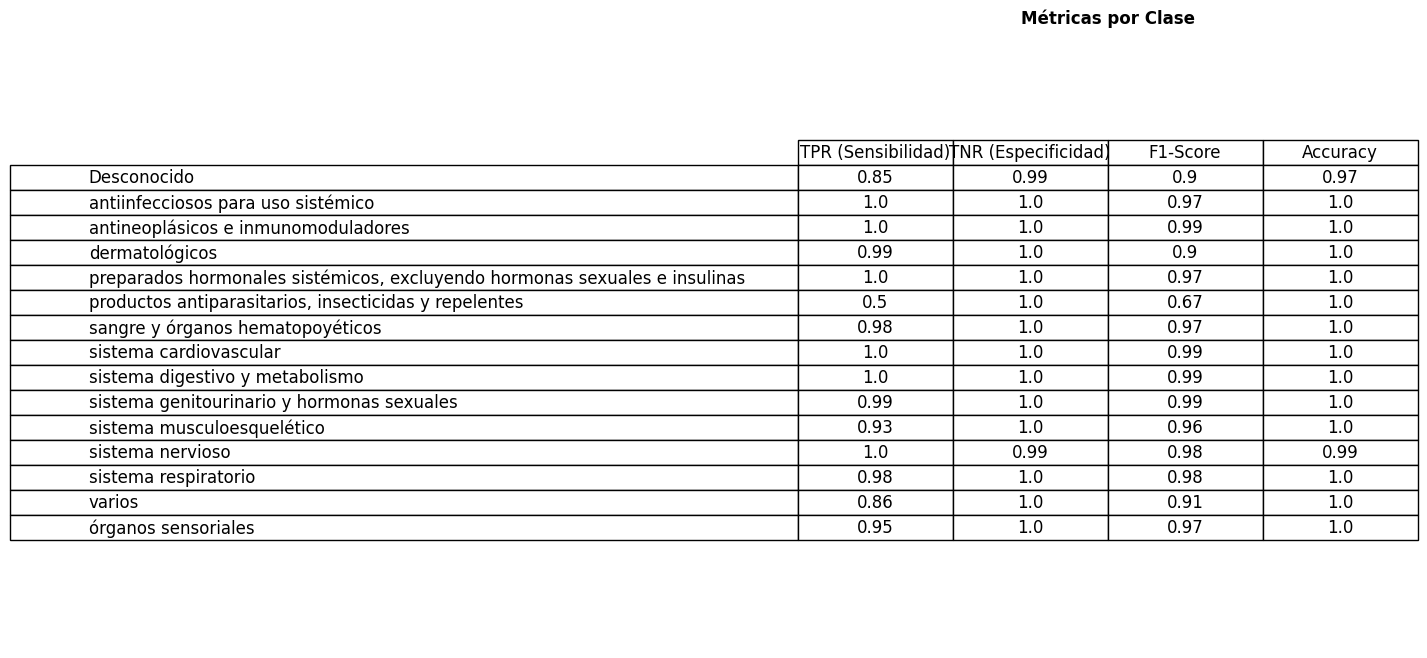

In [23]:
# Matriz de confusión de la random forest
plot_test_confusion_matrix_metrics(y_test, y_test_pred_rf, 'RF')

---
### **4. Análisis de explicabilidad de los modelos**

In [36]:
############################################
# 2. Interpretabilidad: Variables Explicativas #
############################################

# --- Para Regresión Logística ---
# Extraer coeficientes: best_lr.coef_ tiene forma (n_clases, n_features)
feature_names = tfidf_vectorizer.get_feature_names_out()
coef = best_lr.coef_
# Por ejemplo, para cada clase mostramos las 10 características con coeficiente más alto
print("\nTop características por clase (Regresión Logística):")
important_words_by_class = {}
for idx, class_label in enumerate(best_lr.classes_):
    coef_class = coef[idx]
    # Ordenar índices de mayor a menor
    top10_idx = np.argsort(coef_class)[-10:]
    top_features = feature_names[top10_idx]
    top_coef = coef_class[top10_idx]
    class_name = clases_originales[class_label]  # Obtener el nombre de la clase
    print(f"\nClase: {class_label} ({class_name})")
    important_words_by_class[class_name] = []
    for feat, coef_val in zip(top_features[::-1], top_coef[::-1]):
        print(f"{feat}: {coef_val:.4f}")
        important_words_by_class[class_name].append(feat)

# --- Para RandomForest ---
# Extraer feature_importances_
importances = best_rf.feature_importances_
indices_rf = np.argsort(importances)[-10:]
print("\nTop características (RandomForest):")
for idx in indices_rf[::-1]:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


Top características por clase (Regresión Logística):

Clase: 0 (Desconocido)
social: 8.9114
er: 8.5501
basal: 8.5488
mg mg: 8.5345
dutasterida tamsulosina: 8.5149
función renal: 8.2025
eu: 7.9641
producir: 7.7639
mg etoricoxib: 7.6899
código: 7.4711

Clase: 1 (antiinfecciosos para uso sistémico)
sistémico antibacterianos: 27.5348
antibacterianos: 25.4818
sistémico: 22.8701
antiinfecciosos sistémico: 22.1946
antiinfecciosos: 18.0782
ceftriaxona: 8.3131
ribavirina: 7.1785
macrólidos: 6.9793
lactámicos: 6.8215
beta lactámicos: 6.8004

Clase: 2 (antineoplásicos e inmunomoduladores)
antineoplásicos: 25.9388
antineoplásicos inmunomoduladores: 17.5924
inmunomoduladores: 17.3928
inmunosupresores: 12.4729
lmc: 10.4280
anastrozol: 6.6089
pirfenidona: 6.5464
pomalidomida: 6.3544
abiraterona: 6.1117
mielodisplásicos: 6.0693

Clase: 3 (dermatológicos)
preparados: 10.4713
tópico: 9.7164
isotretinoína: 7.9197
contacto: 7.7023
quemaduras: 7.3309
ac: 6.8847
tinea: 6.8256
antifúngicos: 6.5155
acné: 6.2

---
### **5. Otras pruebas**

In [37]:
############################################
# 3. Prueba manual de un medicamento       #
############################################


# Seleccionar manualmente un ejemplo del DataFrame (por ejemplo, la primera fila)
manual_sample = texto_medicamentos_df.iloc[99]
sample_text = manual_sample["texto_completo"]

# Transformar el texto a la representación TF-IDF (usando el vectorizador cargado)
sample_vector = tfidf_vectorizer.transform([sample_text])

# Predecir con ambos modelos (y obtener probabilidades)
lr_proba = best_lr.predict_proba(sample_vector)[0]
rf_proba = best_rf.predict_proba(sample_vector)[0]

print("\n--- Predicción manual ---")
print("Medicamento:", manual_sample["medicamento"])
print("Texto (truncado):", sample_text[:200], "...")
print("\nPredicción Regresión Logística:")
for label, prob in zip(best_lr.classes_, lr_proba):
    print(f"{label}: {prob:.2f}")

print("\nPredicción RandomForest:")
for label, prob in zip(best_rf.classes_, rf_proba):
    print(f"{label}: {prob:.2f}")

# También podemos ver la predicción final
print("\nPredicción final (LogReg):", best_lr.predict(sample_vector)[0])
print("Predicción final (RF):", best_rf.predict(sample_vector)[0])


--- Predicción manual ---
Medicamento: ABSTRAL_300_microgramos_COMPRIMIDOS_SUBLINGUALES
Texto (truncado): tratamiento de dolor irruptivo en pacientes adultos que ya reciben tratamiento con opiáceos para dolor crónico en cáncer el dolor irruptivo es una exacerbación transitoria de dolor que se produce sobr ...

Predicción Regresión Logística:
0: 0.00
1: 0.00
2: 0.00
3: 0.00
4: 0.00
5: 0.00
6: 0.00
7: 0.00
8: 0.00
9: 0.00
10: 0.00
11: 1.00
12: 0.00
13: 0.00
14: 0.00

Predicción RandomForest:
0: 0.00
1: 0.00
2: 0.00
3: 0.00
4: 0.01
5: 0.00
6: 0.00
7: 0.00
8: 0.00
9: 0.00
10: 0.00
11: 0.99
12: 0.01
13: 0.00
14: 0.00

Predicción final (LogReg): 11
Predicción final (RF): 11
